# Python version - Supermodel - Nutrient Pulses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Included N_pulse as a param

In [2]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']
    N_pulse = parameters_dict['N_pulse']


    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - (q_H * E_H * H) - (m_H * H)
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -(PH * (v_m * N) / (k_s + N)) + (0.5 * m_ph * PH) + (0.5 * m_H * H) + (1 * y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                0.5 * m_P * P)

    return dH, dP, dPH, dN

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [4]:

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 30 == 0:
            N_pulse = parameters_dict['N_pulse']  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [5]:
numyears = 36500 # number of years to run simulation

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 50 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.4/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.1/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.1/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.4/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.01/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = 0.03 # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1.0
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [6]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

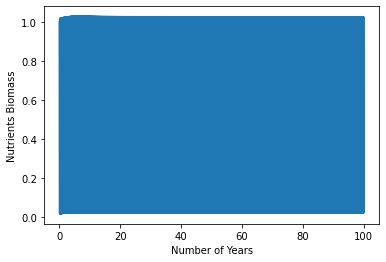

In [7]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

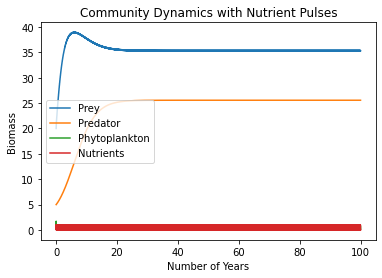

In [8]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.show()

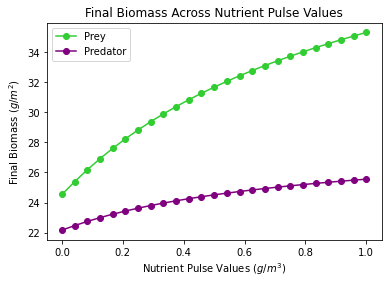

In [9]:
# Define the range of N_pulse_array values to plot
size = 25
N_pulse_array = np.linspace(0.0, 1.0, size)
N_final_array = np.zeros(size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, N_pulse in enumerate(N_pulse_array):
    parameters_dict['N_pulse'] = N_pulse
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    N_final_array[i] = np.mean(N_array[-3650:-1])
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])

# Plot the final abundances
#plt.plot(N_pulse_array, N_final_array, label='Nutrients', color="red", marker="o")
plt.plot(N_pulse_array, H_final_array, label='Prey', color="limegreen", marker="o")
plt.plot(N_pulse_array, P_final_array, label='Predator', color="purple", marker="o")
plt.title('Final Biomass Across Nutrient Pulse Values')
plt.xlabel('Nutrient Pulse Values $(g/m^3)$')
plt.ylabel('Final Biomass $(g/m^2)$')
#plt.ylim(0,75)
plt.legend()

# Show the plot
plt.show()

In [19]:
print(P_final_array)

[14.09816629 14.15740118 14.21325115 14.26606491 14.31613927 14.36372908
 14.40905489 14.45230891 14.49365974 14.5332561  14.57122989 14.60769867
 14.64276764 14.67653138 14.70907522 14.74047642 14.77080515 14.80012537
 14.82849551 14.85596913 14.8825954  14.90841961 14.93348357 14.95782592
 14.98148249]


## Define Default Params

In [15]:
def default_params():
    numyears = 36500 # number of years to run simulation

    #Herbivore parameters:
    r_H = (0.4/365) # prey growth rate
    K_H = 50 # carrying capacity of herbivores
    theta_H = 0 # immigration of herbivores
    c = (0.4/365) # addition to predator from prey
    d = 50 # value of H when predation half its max value
    q_H = 1.0 # proportionality constant for herbivore harvest
    E_H = (0.0/365) # Effort for herbivore harvest
    m_H = (0.1/365) # Herbivore mortality 

    #Predator parameters:
    r_P = (0.1/365) # growth rate of predator 
    K_P = 10 # carrying capactiy of predators 
    b = (0.4/365) # mortality to prey from predator
    theta_P = 0 # immigration of predators  
    q_P = 1.0 # proportionality constant for predators harvest
    E_P = (0.0/365) # Effort for predator harvest
    m_P = (0.01/365) # Predator mortality

    #Phytoplankton parameters: 
    v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
    k_s = 1 # half saturation constant
    m_ph = 0.03 # phytoplankton mortality ## daily rate ?
    y = 0.1 # unassimilated phytoplankton 

    #Grazing parameters: 
    r_m = 1.1 #1.1 # grazing of fish on phytoplankton ## daily ??
    kg = 12
    N_pulse = 1.0
    # Timesteps
    dt = 0.1

    parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }
    
    return parameters_dict

# Section 1 

## Harvest Curves Under Nutrient Pulses

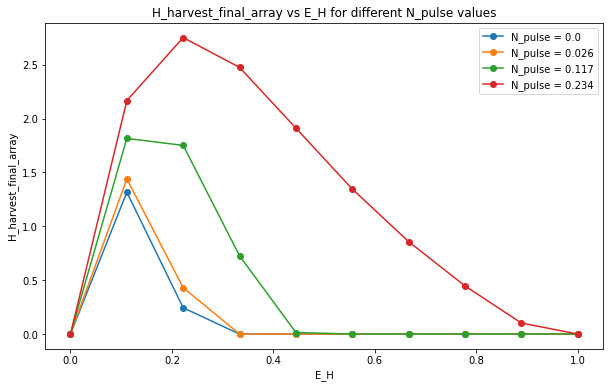

In [19]:
parameters_dict = default_params()

# Define parameters
N_pulse_values = [0.0, 0.026, 0.117, 0.234]
size = 10
E_H_array = np.linspace(0, 1.0, size)

# Initialize array to store results
H_harvest_final_array = np.zeros((len(N_pulse_values), size))

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, N_pulse in enumerate(N_pulse_values):
    plt.plot(E_H_array, H_harvest_final_array[idx]*365, label=f'N_pulse = {N_pulse}', marker ="o")

plt.xlabel('E_H')
plt.ylabel('H_harvest_final_array')
plt.title('H_harvest_final_array vs E_H for different N_pulse values')
plt.legend()
plt.show()

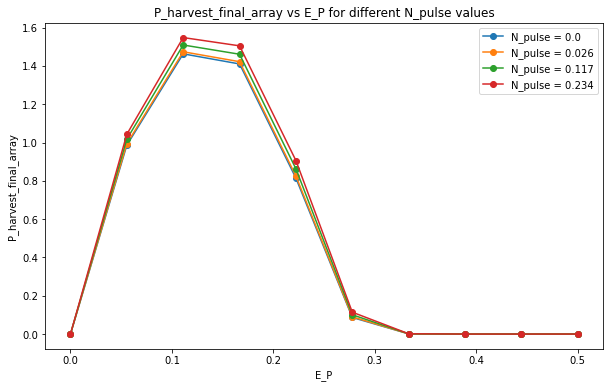

In [23]:
parameters_dict = default_params()

# Define parameters
N_pulse_values = [0.0, 0.026, 0.117, 0.234]
size = 10
E_P_array = np.linspace(0, 0.5, size)

# Initialize array to store results
P_harvest_final_array = np.zeros((len(N_pulse_values), size))

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_params()
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, N_pulse in enumerate(N_pulse_values):
    plt.plot(E_P_array, P_harvest_final_array[idx]*365, label=f'N_pulse = {N_pulse}', marker ="o")

plt.xlabel('E_P')
plt.ylabel('P_harvest_final_array')
plt.title('P_harvest_final_array vs E_P for different N_pulse values')
plt.legend()
plt.show()

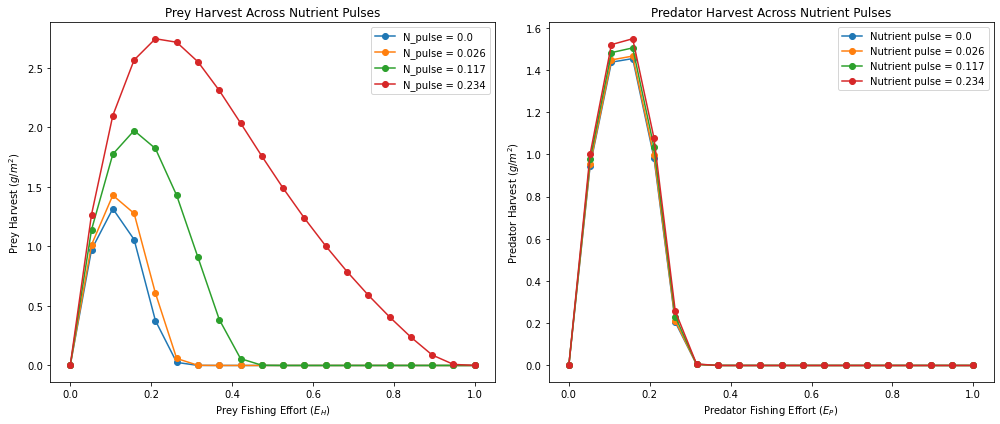

In [24]:
#Define parameters
N_pulse_values = [0.0, 0.026, 0.117, 0.234]
size = 20
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

# Initialize arrays to store results
H_harvest_final_array = np.zeros((len(N_pulse_values), size))
P_harvest_final_array = np.zeros((len(N_pulse_values), size))

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        # Calculate for E_H
        E_H = E_H_array[i]
        parameters_dict = default_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        
        # Calculate for E_P
        E_P = E_P_array[i]
        parameters_dict = default_params()
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the results for H_harvest_final_array
for idx, N_pulse in enumerate(N_pulse_values):
    axs[0].plot(E_H_array, H_harvest_final_array[idx] * 365, label=f'N_pulse = {N_pulse}', marker="o")

axs[0].set_xlabel('Prey Fishing Effort ($E_H$)')
axs[0].set_ylabel('Prey Harvest ($g/m^2$)')
axs[0].set_title('Prey Harvest Across Nutrient Pulses')
axs[0].legend()

# Plot the results for P_harvest_final_array
for idx, N_pulse in enumerate(N_pulse_values):
    axs[1].plot(E_P_array, P_harvest_final_array[idx] * 365, label=f'Nutrient pulse = {N_pulse}', marker="o")

axs[1].set_xlabel('Predator Fishing Effort ($E_P$)')
axs[1].set_ylabel('Predator Harvest ($g/m^2$)')
axs[1].set_title('Predator Harvest Across Nutrient Pulses')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Section 1 -  Supplemental Figures 

In [ ]:
#Define parameters
N_pulse_values = [0.0, 0.026, 0.117, 0.234]
size = 5
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

# Initialize arrays to store results
H_harvest_final_array = np.zeros((len(N_pulse_values), size))
H_final_array = np.zeros((len(N_pulse_values), size))
P_harvest_final_array = np.zeros((len(N_pulse_values), size))
P_final_array = np.zeros((len(N_pulse_values), size))

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        # Calculate for E_H
        E_H = E_H_array[i]
        parameters_dict = default_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        H_final_array[idx, i] = np.mean(H_array[-3650:-1])
        P_final_array[idx, i] = np.mean(P_array[-3650:-1])
        
        # Calculate for E_P
        E_P = E_P_array[i]
        parameters_dict = default_params()
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        P_harvest_final_array[idx, i] = np.mean(P_harvest_array[-3650:-1])
        H_final_array[idx, i] = np.mean(H_array[-3650:-1])
        P_final_array[idx, i] = np.mean(P_array[-3650:-1])

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot the results for H_harvest_final_array
for idx, N_pulse in enumerate(N_pulse_values):
    axs[0,0].plot(E_H_array, H_harvest_final_array[idx] * 365, label=f'N_pulse = {N_pulse}', marker="o")

ax1.set_xlabel('Prey Fishing Effort ($E_H$)')
ax1.set_ylabel('Prey Harvest ($g/m^2$)')
ax1.set_title('Prey Harvest Across Nutrient Pulses')
ax1.legend()

# Plot the results for P_harvest_final_array
for idx, N_pulse in enumerate(N_pulse_values):
    axs[1].plot(E_P_array, P_harvest_final_array[idx] * 365, label=f'Nutrient pulse = {N_pulse}', marker="o")

axs[1].set_xlabel('Predator Fishing Effort ($E_P$)')
axs[1].set_ylabel('Predator Harvest ($g/m^2$)')
axs[1].set_title('Predator Harvest Across Nutrient Pulses')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


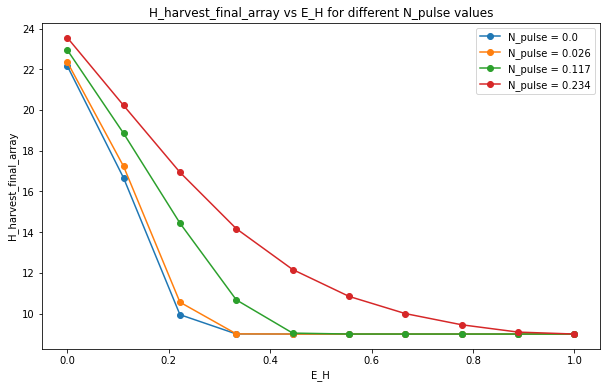

In [36]:
parameters_dict = default_params()

# Define parameters
N_pulse_values = [0.0, 0.026, 0.117, 0.234]
size = 10
E_H_array = np.linspace(0, 1.0, size)

# Initialize array to store results
H_harvest_final_array = np.zeros((len(N_pulse_values), size))
H_final_array = np.zeros((len(N_pulse_values), size))
P_final_array = np.zeros((len(N_pulse_values), size))

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        E_H = E_H_array[i]
        parameters_dict = default_params()
        parameters_dict['E_H'] = E_H / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        H_final_array[idx, i] = np.mean(H_array[-3650:-1])
        P_final_array[idx, i] = np.mean(P_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, N_pulse in enumerate(N_pulse_values):
    plt.plot(E_H_array, P_final_array[idx], label=f'N_pulse = {N_pulse}', marker ="o")

plt.xlabel('E_H')
plt.ylabel('H_harvest_final_array')
plt.title('H_harvest_final_array vs E_H for different N_pulse values')
plt.legend()
plt.show()

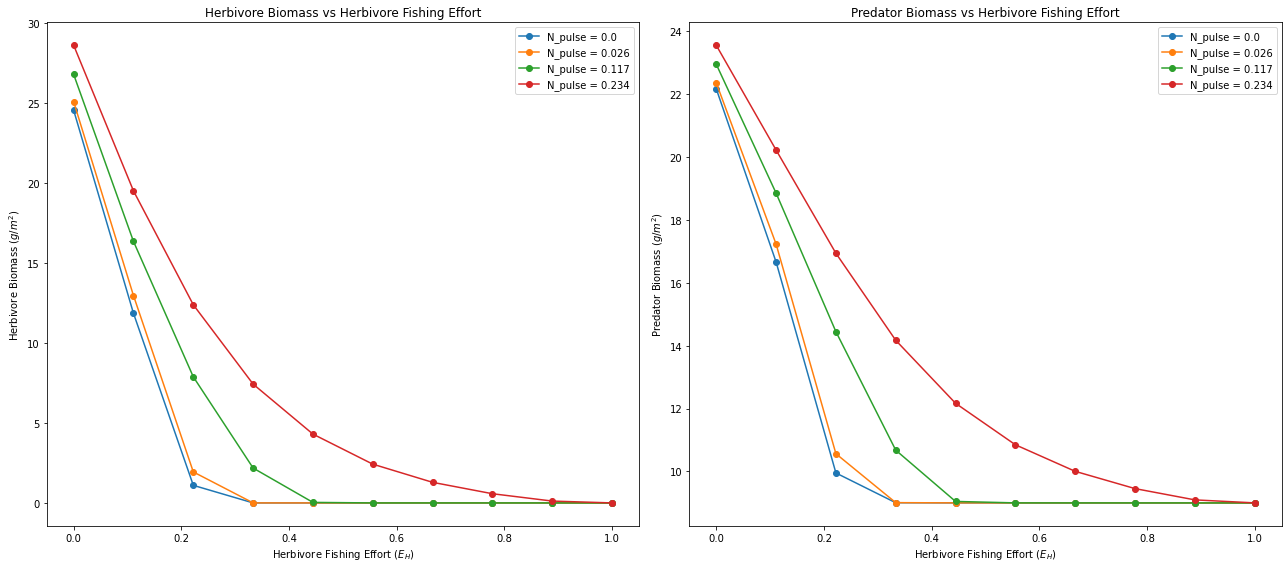

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot the herbivore biomass (H_final_array)
for idx, N_pulse in enumerate(N_pulse_values):
    ax1.plot(E_H_array, H_final_array[idx], label=f'N_pulse = {N_pulse}', marker="o")

ax1.set_xlabel('Herbivore Fishing Effort ($E_H$)')
ax1.set_ylabel('Herbivore Biomass ($g/m^2$)')
ax1.set_title('Herbivore Biomass vs Herbivore Fishing Effort')
ax1.legend()

# Plot the predator biomass (P_final_array)
for idx, N_pulse in enumerate(N_pulse_values):
    ax2.plot(E_H_array, P_final_array[idx], label=f'N_pulse = {N_pulse}', marker="o")

ax2.set_xlabel('Herbivore Fishing Effort ($E_H$)')
ax2.set_ylabel('Predator Biomass ($g/m^2$)')
ax2.set_title('Predator Biomass vs Herbivore Fishing Effort')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

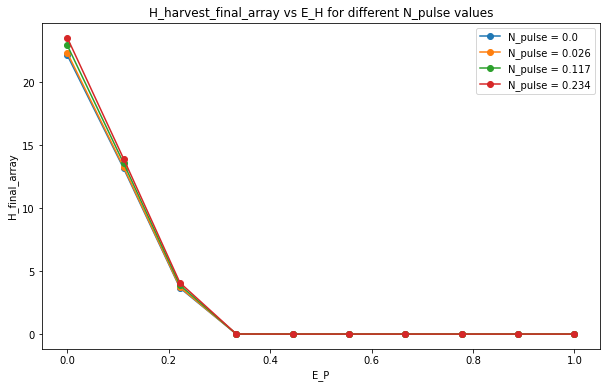

In [38]:
parameters_dict = default_params()

# Define parameters
N_pulse_values = [0.0, 0.026, 0.117, 0.234]
size = 10
E_P_array = np.linspace(0, 1.0, size)

# Initialize array to store results
P_harvest_final_array = np.zeros((len(N_pulse_values), size))
H_final_array = np.zeros((len(N_pulse_values), size))
P_final_array = np.zeros((len(N_pulse_values), size))

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        E_P = E_P_array[i]
        parameters_dict = default_params()
        parameters_dict['E_P'] = E_P / 365
        parameters_dict['N_pulse'] = N_pulse  
        H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
        H_harvest_final_array[idx, i] = np.mean(H_harvest_array[-3650:-1])
        H_final_array[idx, i] = np.mean(H_array[-3650:-1])
        P_final_array[idx, i] = np.mean(P_array[-3650:-1])

# Plot the results
plt.figure(figsize=(10, 6))

for idx, N_pulse in enumerate(N_pulse_values):
    plt.plot(E_P_array, P_final_array[idx], label=f'N_pulse = {N_pulse}', marker ="o")

plt.xlabel('E_P')
plt.ylabel('H_final_array')
plt.title('H_harvest_final_array vs E_H for different N_pulse values')
plt.legend()
plt.show()

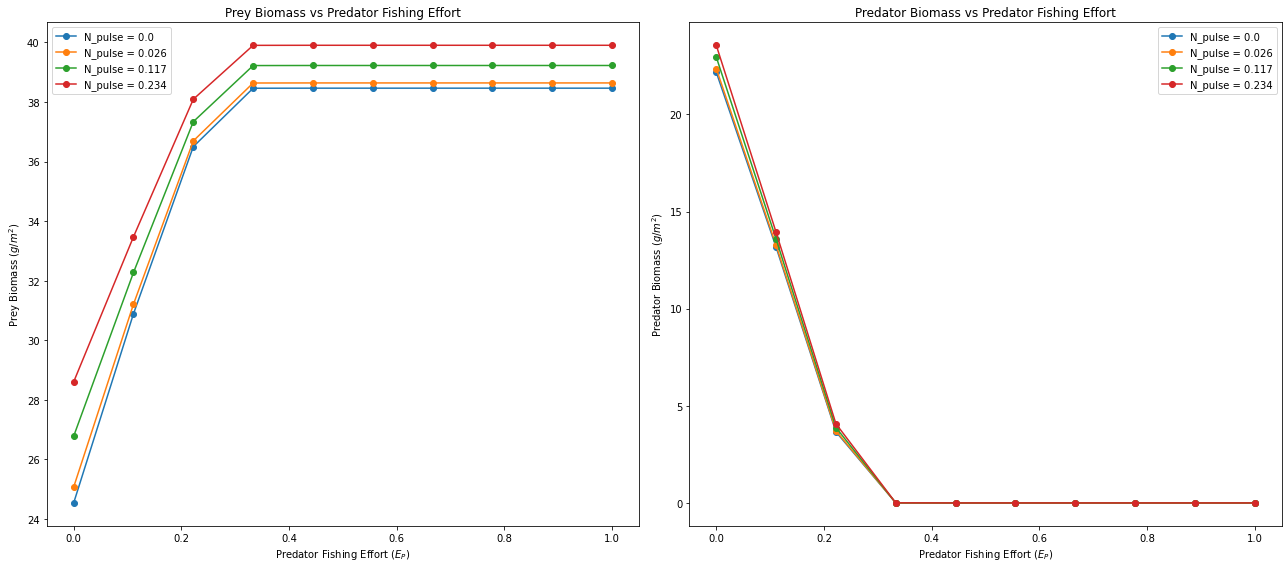

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot the herbivore biomass (H_final_array)
for idx, N_pulse in enumerate(N_pulse_values):
    ax1.plot(E_P_array, H_final_array[idx], label=f'N_pulse = {N_pulse}', marker="o")

ax1.set_xlabel('Predator Fishing Effort ($E_P$)')
ax1.set_ylabel('Prey Biomass ($g/m^2$)')
ax1.set_title('Prey Biomass vs Predator Fishing Effort')
ax1.legend()

# Plot the predator biomass (P_final_array)
for idx, N_pulse in enumerate(N_pulse_values):
    ax2.plot(E_P_array, P_final_array[idx], label=f'N_pulse = {N_pulse}', marker="o")

ax2.set_xlabel('Predator Fishing Effort ($E_P$)')
ax2.set_ylabel('Predator Biomass ($g/m^2$)')
ax2.set_title('Predator Biomass vs Predator Fishing Effort')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Section 2

## Harvest Heatmaps

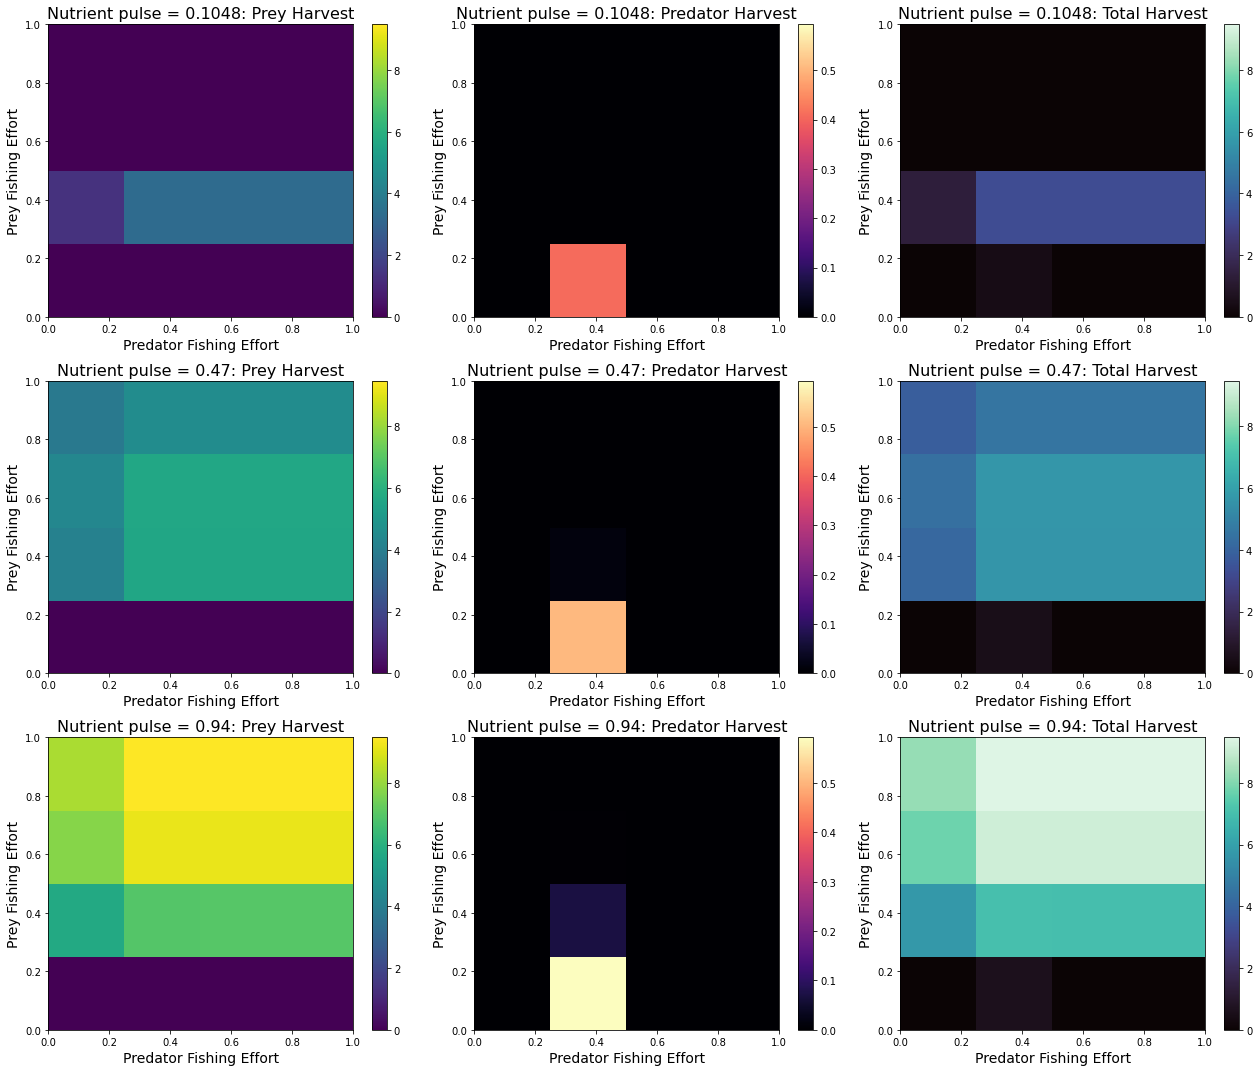

In [41]:
# Define parameters
parameters_dict = default_params()
N_pulse_values = [0.1048, 0.47, 0.94]
size = 5
heatmap_harvest_H = np.zeros((len(N_pulse_values), size, size))
heatmap_harvest_P = np.zeros((len(N_pulse_values), size, size))
heatmap_harvest_T = np.zeros((len(N_pulse_values), size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

# Compute results for each N_pulse value
for idx, N_pulse in enumerate(N_pulse_values):
    for i in range(size):
        for j in range(size):
            E_H = E_H_array[i]
            E_P = E_P_array[j]
            parameters_dict['E_H'] = E_H / 365
            parameters_dict['E_P'] = E_P / 365
            parameters_dict['N_pulse'] = N_pulse
            
            H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
            H_harvest_last = np.mean(H_harvest_array[-3650:])
            P_harvest_last = np.mean(P_harvest_array[-3650:])
            T_harvest_last = H_harvest_last + P_harvest_last
            heatmap_harvest_H[idx, i, j] = H_harvest_last
            heatmap_harvest_P[idx, i, j] = P_harvest_last
            heatmap_harvest_T[idx, i, j] = T_harvest_last

            

max_H = np.max(heatmap_harvest_H)
max_P = np.max(heatmap_harvest_P)
max_T = np.max(heatmap_harvest_T)

# Plot the results outside the loop
fig, axes = plt.subplots(nrows=len(N_pulse_values), ncols=3, figsize=(18, 5 * len(N_pulse_values)))

for idx, N_pulse in enumerate(N_pulse_values):
    ax0, ax1, ax2 = axes[idx]
    
    im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_harvest_H[idx]*365, cmap=plt.cm.get_cmap('viridis'), shading='auto', vmax = max_H*365)
    fig.colorbar(im, ax=ax0, orientation="vertical", pad=0.05)
    ax0.set_title(f"Nutrient pulse = {N_pulse}: Prey Harvest", fontsize = 16)
    ax0.set_ylabel("Prey Fishing Effort", fontsize = 14)
    ax0.set_xlabel("Predator Fishing Effort", fontsize = 14)

    im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_harvest_P[idx]*365, cmap=plt.cm.get_cmap('magma'), shading='auto', vmax = max_P*365)
    fig.colorbar(im, ax=ax1, orientation="vertical", pad=0.05)
    ax1.set_title(f"Nutrient pulse = {N_pulse}: Predator Harvest", fontsize = 16)
    ax1.set_ylabel("Prey Fishing Effort", fontsize = 14)
    ax1.set_xlabel("Predator Fishing Effort", fontsize = 14)

    im = ax2.pcolormesh(E_P_array, E_H_array, heatmap_harvest_T[idx]*365, cmap=plt.cm.get_cmap('mako'), shading='auto', vmax = max_T*365)
    fig.colorbar(im, ax=ax2, orientation="vertical", pad=0.05)
    ax2.set_title(f"Nutrient pulse = {N_pulse}: Total Harvest", fontsize = 16)
    ax2.set_ylabel("Prey Fishing Effort", fontsize = 14)
    ax2.set_xlabel("Predator Fishing Effort", fontsize = 14)

plt.tight_layout()

#plt.savefig("figs/N_pulse_heatmap_harvest.jpg",
            #format='jpeg',
            #dpi=300,
            #bbox_inches='tight')

plt.show()